Data visualization and transformation is an important part of every model. Now that we have our dataset downloaded, let's learn more about audio data visualization and transforming this dataset. We will be using [tf.signal](https://www.tensorflow.org/api_docs/python/tf/signal) and [tfio.audio](https://www.tensorflow.org/io/api_docs/python/tfio/audio/spectrogram) processing operations to transform the data. Once we understand these concepts we will create our spectrogram images of the yes/no dataset to be used in the computer vision model.

## Load the dataset

Here we import the packages and create a `load_audio` and `load_audio_files` function to load audio files from a specified path into a dataset.

In [1]:
%pip install tensorflow_io


Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install tensorflow-io

In [3]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np


In [4]:
import tensorflow_io as tfio

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/tensorf

In [5]:
# import os
# import matplotlib.pyplot as plt
# from pathlib import Path
# import tensorflow as tf
# import tensorflow_io as tfio
# import IPython.display as ipd
# import numpy as np

In [6]:
def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
        
    return dataset

- Call the `load_audio_files` function for each class we are going to use, then print the length of the dataset.

In [7]:
trainset_speechcommands_yes = load_audio_files('./data/yes', 'yes')
trainset_speechcommands_no = load_audio_files('./data/no', 'no')

print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

2025-09-09 05:22:50.627358: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-09-09 05:22:50.627435: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fcutluamixnjxks): /proc/driver/nvidia/version does not exist
2025-09-09 05:22:50.634809: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Length of yes dataset: 4044
Length of no dataset: 3941


- Now let's grab an example item from each dataset. We can see the waveform, sample_rate, label, and id.

In [8]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]}')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: [-0.0027771  -0.00537109 -0.00338745 ... -0.00112915 -0.00131226
 -0.00140381]
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714
No Waveform: [0.00720215 0.00610352 0.00552368 ... 0.00979614 0.0085144  0.00921631]
No Sample Rate: 16000
No Label: no
No ID: 012c8314


## Transform and visualize

Our data is ready! Let's breakdown some of the audio transforms and visualize them to better understand what they are and what they tell us about the data.


### Waveform

The waveform is generated by taking the sample rate and amplitude and representing the signal visually. This signal can be represented as a `waveform` which is the `signal` representation over time in a graphical format. The audio can be recorded in different `channels`. For example stereo recordings have 2 channels, right and left.

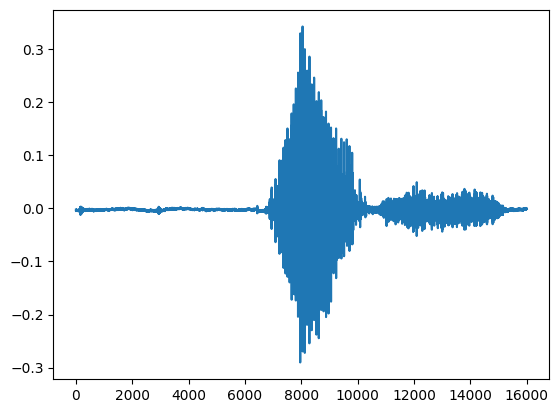

In [9]:
timescale = np.arange(yes_waveform.shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, yes_waveform.numpy())
plt.show()

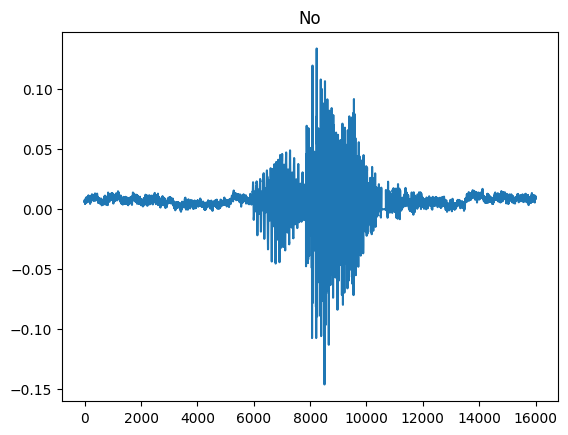

In [10]:
timescale = np.arange(no_waveform.shape[0])
plt.title("No")
plt.figsize=(12, 8)
plt.plot(timescale, no_waveform.numpy())
plt.show()

### Spectrogram

Next we will look at the `Spectrogram`. What is a spectrogram anyway?! A spectrogram allows you to visualize the amplitude as a function of frequency and time in the form of an image, where the 'x' axis represents time, the 'y' axis represents frequency, and the color represents the amplitude. This image is what we will use for our computer vision classification on our audio files. 

Here we look at two different ways to create the spectrogram from the waveform. First we want to make our waveforms all equal lenths so we will pad them with zeros. Then we apply to transforms [tf.signal.stft](https://www.tensorflow.org/api_docs/python/tf/signal/stft) and [tfio.audio.spectrogram](https://www.tensorflow.org/io/api_docs/python/tfio/audio/spectrogram?hl=da).


In [11]:
def get_spectrogram(waveform):
    
    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)
    
    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)
    
    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

## This funciton has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

- Lets listen to an example and then create a methond `plot_spectorgram` to display the two spectorgrams created.

In [12]:
spectrogram, spect = get_spectrogram(yes_waveform)

print('Label:', 'yes')
print('Waveform shape:', yes_waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Spect shape:', spect.shape)
print('Audio playback')
ipd.Audio(yes_waveform.numpy(), rate=16000)

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Spect shape: (125, 128)
Audio playback


In [13]:
!pwd
!ls -lrta

/learn
total 20
drwxrwxrwx  2 root root 4096 Nov 12  2022 bert
drwxrwxrwx  5 root root 4096 Nov 12  2022 .
drwxrwxrwx  2 root root 4096 Nov 12  2022 .vector_cache
drwxr-xr-x 23 root root 4096 Sep  8 20:25 ..
drwxrwxrwx 44 root root 4096 Sep  9 05:03 data


In [14]:
!ls -lrta ./data

total 2555436
-rwxrwxrwx  1 root        root         170498071 Jun  4  2009 cifar-10-python.tar.gz
-rw-r-----  1 mslearnuser mslearnuser      18651 Jul 27  2017 LICENSE
drwxr-x---  2 mslearnuser mslearnuser     172032 Mar 28  2018 four
-rw-r-----  1 mslearnuser mslearnuser       6148 Mar 28  2018 .DS_Store
-rw-r-----  1 mslearnuser mslearnuser     268262 Mar 28  2018 validation_list.txt
-rw-r-----  1 mslearnuser mslearnuser     295833 Mar 28  2018 testing_list.txt
drwxr-x---  2 mslearnuser mslearnuser     172032 Apr 11  2018 off
drwxr-x---  2 mslearnuser mslearnuser      69632 Apr 11  2018 forward
drwxr-x---  2 mslearnuser mslearnuser     208896 Apr 11  2018 five
drwxr-x---  2 mslearnuser mslearnuser     176128 Apr 11  2018 on
drwxr-x---  2 mslearnuser mslearnuser     192512 Apr 11  2018 yes
drwxr-x---  2 mslearnuser mslearnuser     180224 Apr 11  2018 six
drwxr-x---  2 mslearnuser mslearnuser     184320 Apr 11  2018 down
drwxr-x---  2 mslearnuser mslearnuser     114688 Apr 11  2018 ho

In [15]:
!ls -lrta ./data/yes

total 128020
-rw-r-----  1 mslearnuser mslearnuser  24620 Mar 28  2018 fbe51750_nohash_1.wav
-rw-r-----  1 mslearnuser mslearnuser  25986 Mar 28  2018 fbe51750_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 fbdc07bb_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f632210f_nohash_1.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f632210f_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f568162b_nohash_3.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f568162b_nohash_2.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f568162b_nohash_1.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f568162b_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f2b8fc18_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 eb76bc68_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  22336 Mar 28  2018 e91d173e_nohash_1.wav
-rw-r-----  1 mslearnuser m

In [16]:
!ls -lrta ./data/no

total 124364
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 ffa76c4a_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 ff63ab0b_nohash_2.wav
-rw-r-----  1 mslearnuser mslearnuser  31448 Mar 28  2018 ff63ab0b_nohash_1.wav
-rw-r-----  1 mslearnuser mslearnuser  30082 Mar 28  2018 ff63ab0b_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 fb01a182_nohash_1.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 fb01a182_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  26794 Mar 28  2018 fa70c187_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f810e799_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f6581345_nohash_1.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f6581345_nohash_0.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f638a812_nohash_1.wav
-rw-r-----  1 mslearnuser mslearnuser  32044 Mar 28  2018 f638a812_nohash_0.wav
-rw-r-----  1 mslearnuser m

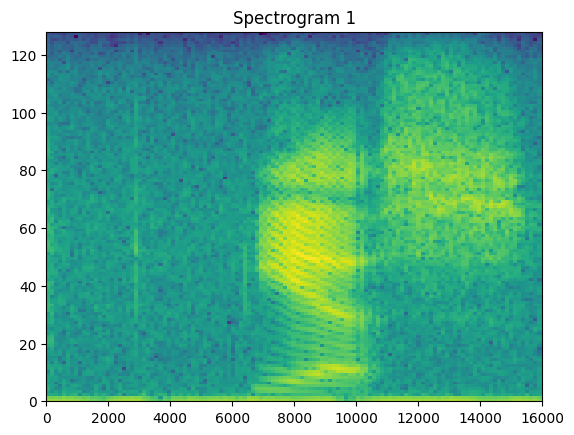

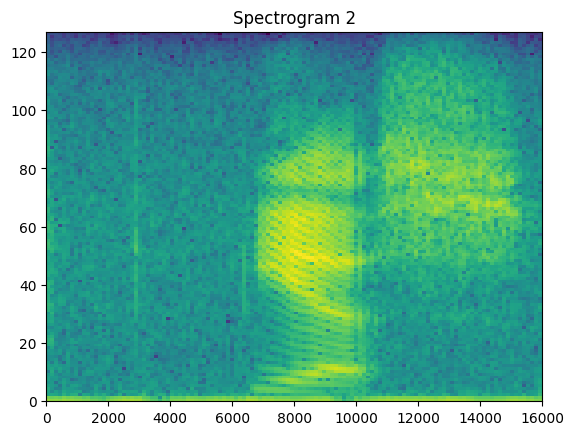

In [17]:
def plot_spectrogram(spectrogram, ax, title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 16000])
    ax.set_title(title)
    
fig, ax = plt.subplots()  
plot_spectrogram(spectrogram.numpy(), ax, 'Spectrogram 1')
plt.show()

fig, ax = plt.subplots()  
plot_spectrogram(spect.numpy(), ax, 'Spectrogram 2')
plt.show()


## Save the spectrogram as an image

We have broken down some of the ways to understand our audio data and different transformations we can use on our data. Now lets create the images we will use for classification. 

Below is a function to create the Spectrogram image for classification.

In [18]:
def create_images(dataset, label_dir):
    # make directory
    test_directory = f'./data/test/{label_dir}/'
    train_directory = f'./data/train/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)
    
    for i, data in enumerate(dataset):

        waveform = data[0]
        spectrogram, spect = get_spectrogram(waveform)

        # Split test and train images by 30%
        if i % 3 == 0:
            plt.imsave(f'./data/test/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')
        else:
            plt.imsave(f'./data/train/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')

        


In [19]:
create_images(trainset_speechcommands_yes, 'yes')
create_images(trainset_speechcommands_no, 'no')

In [20]:
!ls ./data/test/no
!ls ./data/test/yes


spec_img0.png	  spec_img189.png   spec_img2778.png  spec_img3663.png
spec_img1002.png  spec_img1890.png  spec_img2781.png  spec_img3666.png
spec_img1005.png  spec_img1893.png  spec_img2784.png  spec_img3669.png
spec_img1008.png  spec_img1896.png  spec_img2787.png  spec_img3672.png
spec_img1011.png  spec_img1899.png  spec_img279.png   spec_img3675.png
spec_img1014.png  spec_img1902.png  spec_img2790.png  spec_img3678.png
spec_img1017.png  spec_img1905.png  spec_img2793.png  spec_img3681.png
spec_img102.png   spec_img1908.png  spec_img2796.png  spec_img3684.png
spec_img1020.png  spec_img1911.png  spec_img2799.png  spec_img3687.png
spec_img1023.png  spec_img1914.png  spec_img2802.png  spec_img369.png
spec_img1026.png  spec_img1917.png  spec_img2805.png  spec_img3690.png
spec_img1029.png  spec_img192.png   spec_img2808.png  spec_img3693.png
spec_img1032.png  spec_img1920.png  spec_img2811.png  spec_img3696.png
spec_img1035.png  spec_img1923.png  spec_img2814.png  spec_img3699.png
spec_img1

We now have our audio as spectrogram images and are ready to build the model!